Correct at ff, train_act,train_act,train_act_der,test_act,test_act

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
import copy

data = load_boston()
y_indices = data.target
y = np.matrix(data.target).T
X = np.matrix(data.data)
M = X.shape[0]
N = X.shape[1]

print(X.shape)

print(y.shape)

(506, 13)
(506, 1)


In [2]:
import random
import warnings
warnings.filterwarnings("ignore")

# Normalize each input feature

def normalize(X):
    M = X.shape[0]
    XX = X - np.tile(np.mean(X,0),[M,1])
    XX = np.divide(XX, np.tile(np.std(XX,0),[M,1]))
    return np.nan_to_num(XX, copy=True,nan=0.0)

XX = normalize(X)

idx = np.arange(0,M)

# Partion data into training and testing dataset

random.shuffle(idx)
percent_train = .6
m_train = int(M * percent_train)
m_test = M - m_train
train_idx = idx[0:m_train]
test_idx = idx[m_train:M+1]
X_train = XX[train_idx,:];
X_test = XX[test_idx,:];

y_train = y[train_idx];
y_test = y[test_idx];
# y_test_indices = y_indices[test_idx]
print('=======X train =======')
print(X_train.shape,y_train.shape)
print('=======X test =======')
print(X_test.shape,y_test.shape)
# print(y_train)

=======X train =======
(303, 13) (303, 1)
=======X test =======
(203, 13) (203, 1)


In [3]:
# Let's start with a 3-layer network with sigmoid activation functions,
# 6 units in layer 1, and 5 units in layer 2.

h3 = 2
h2 = 5
h1 = 10

W = [[], np.random.normal(0,0.1,[N,h1]),
         np.random.normal(0,0.1,[h1,h2]),
         np.random.normal(0,0.1,[h2,h3]),
         np.random.normal(0,0.1,[h3,1])]
b = [[], np.random.normal(0,0.1,[h1,1]),
         np.random.normal(0,0.1,[h2,1]),
         np.random.normal(0,0.1,[h3,1]),
         np.random.normal(0,0.1,[1,1])]
L = len(W)-1
# print(W)

In [4]:
def sigmoid_act(z):
    return 1/(1+np.exp(-z))

def softmax_act(z):
    exps = np.exp(z)
    return exps / np.sum(exps)

def sigmoid_actder(z):
    az = sigmoid_act(z)
    prod = np.multiply(az,1-az)
    return prod

def tanh_act(z):
    return np.tanh(z)

def tanh_actder(z):
    az = tanh_act(z)
    prod = np.multiply(az,az)
    return (1 - prod)

def relu_act(z):
    return np.maximum(0,z)

def relu_actder(z):
    z[z<=0] = 0
    z[z>0] = 1
    return z

def linear_act(z):
    return z
    
def linear_actder(z):
    return 1

def leaky_relu_act(z):
    return np.maximum(0.2* z,z)

def leaky_relu_actder(z):
    dz = np.ones_like(z)
    dz[z < 0] = 0.2
    return dz

In [5]:
def ff(x,W,b):
    L = len(W)-1
    a = x
    for l in range(1,L+1):
        z = W[l].T*a+b[l]
        if (l == L):
            a = leaky_relu_act(z)
        else:
            a = leaky_relu_act(z)
    return a

####MSE
# def loss_multi(y, yhat):
#     return - np.dot(y, np.log(yhat))

def loss(y, yhat):
    return - np.dot(y, np.log(yhat))

def loss_mse(y,yhat):
    return np.sum(np.power((y-yhat),2))/ y.shape[0]

In [6]:
# Train for 100 epochs with mini-batch size 1

cost_arr = [] 
cost_arr_test = []
best_this_loss = 1e-16
alpha = 0.001
max_iter = 100
iter_stop = 0

for iter in range(0, max_iter):
    loss_this_iter = 0
    loss_this_iter_test = 0
    order = np.random.permutation(m_train)
    order_test = np.random.permutation(m_test)
    for i in range(0, m_train):
        
        # Grab the pattern order[i]
        
        x_this = X_train[order[i],:].T
        y_this = y_train[order[i],:]

        # Feed forward step
        
        a = [x_this]
        z = [[]]
        delta = [[]]
        dW = [[]]
        db = [[]]
        for l in range(1,L+1):
#             print(l,W[l].shape,a[l-1].shape,b[l].shape)
            z.append(W[l].T*a[l-1]+b[l])
            if (l == L):
                a.append(leaky_relu_act(z[l]))
            else:
                a.append(leaky_relu_act(z[l]))
            # Just to give arrays the right shape for the backprop step
            delta.append([]); dW.append([]); db.append([])
            
        loss_this_pattern = loss_mse(y_this, a[L])
        loss_this_iter = loss_this_iter + loss_this_pattern
        
        delta[L] = a[L] - np.matrix(y_this).T
        for l in range(L,0,-1):
            db[l] = delta[l].copy()
            dW[l] = a[l-1] * delta[l].T
            if l > 1:
                # depends on your activation function in th at particular layer 
                # in this case all our activation functions are sigmoid 
                delta[l-1] = np.multiply(leaky_relu_actder(z[l-1]), W[l] *
                             delta[l])
                
        # Check delta calculation
        
        if False:
            print('Target: %f' % y_this)
            print('y_hat: %f' % a[L][0,0])
            print(db)
            y_pred = ff(x_this,W,b)
            diff = 1e-3
            W[1][10,0] = W[1][10,0] + diff
            y_pred_db = ff(x_this,W,b)
            L1 = loss(y_this,y_pred)
            L2 = loss(y_this,y_pred_db)
            db_finite_difference = (L2-L1)/diff
            print('Original out %f, perturbed out %f' %
                 (y_pred[0,0], y_pred_db[0,0]))
            print('Theoretical dW %f, calculated db %f' %
                  (dW[1][10,0], db_finite_difference[0,0]))
        
        for l in range(1,L+1):            
            W[l] = W[l] - alpha * dW[l]
            b[l] = b[l] - alpha * db[l]
            
        
    for j in range(0, m_test):

        # Grab the pattern order[j]

        x_this_test = X_test[order_test[j],:].T
        y_this_test = y_test[order_test[j],:]

        # Feed forward step
        a_test = [x_this_test]
        z_test = [[]]
        for l in range(1,L+1):
            z_test.append(W[l].T*a_test[l-1]+b[l])
            if (l == L):
                a_test.append(leaky_relu_act(z_test[l]))
            else:
                a_test.append(leaky_relu_act(z_test[l]))
        
        loss_this_pattern_test = loss_mse(y_this_test,a_test[L])
        loss_this_iter_test = loss_this_iter_test + loss_this_pattern_test
            
        # Backprop step. Note that derivative of multinomial cross entropy
        # loss is the same as that of binary cross entropy loss. See
        # https://levelup.gitconnected.com/killer-combo-softmax-and-cross-entropy-5907442f60ba
        # for a nice derivation.

#     print(loss_this_iter)
    cost_arr.append(loss_this_iter) #/m_train)
    cost_arr_test.append(loss_this_iter_test) #/m_test)
    
    if loss_this_iter_test < best_this_loss:
        w_best = copy.deepcopy(W) #w
        b_best = copy.deepcopy(b) #b
        iter_best = iter
        print('Early stopping at Epoch %d' % (iter))
        break
    
#     tol = 0.0001
#     if len(cost_arr_test) > 50:
#         if cost_arr_test[-2] - cost_arr_test[-1] < tol:
#             iter_stop = iter
#             print('Epoch %d train loss %f' % (iter, loss_this_iter))
#             print('Epoch %d test loss %f' % (iter, loss_this_iter_test))
#             print('Iter stop: ', iter_stop)
#             break

    print('Epoch %d train loss %f' % (iter, loss_this_iter))
    print('Epoch %d test loss %f' % (iter, loss_this_iter_test))
    iter_stop = iter


Epoch 0 train loss 144075.599602
Epoch 0 test loss 70074.741018
Epoch 1 train loss 91398.327085
Epoch 1 test loss 44701.481176
Epoch 2 train loss 62522.068931
Epoch 2 test loss 30713.696868
Epoch 3 train loss 46565.910015
Epoch 3 test loss 22994.616571
Epoch 4 train loss 37408.527676
Epoch 4 test loss 18114.021448
Epoch 5 train loss 23930.319367
Epoch 5 test loss 4916.884873
Epoch 6 train loss 9394.003349
Epoch 6 test loss 4251.851930
Epoch 7 train loss 7546.744553
Epoch 7 test loss 3862.974801
Epoch 8 train loss 6290.120870
Epoch 8 test loss 3499.293114
Epoch 9 train loss 5680.163530
Epoch 9 test loss 3940.494450
Epoch 10 train loss 5124.893135
Epoch 10 test loss 3787.217499
Epoch 11 train loss 4924.507114
Epoch 11 test loss 3821.579682
Epoch 12 train loss 4355.141461
Epoch 12 test loss 4001.563784
Epoch 13 train loss 4607.688320
Epoch 13 test loss 3188.192683
Epoch 14 train loss 4329.411706
Epoch 14 test loss 4045.511589
Epoch 15 train loss 4057.773578
Epoch 15 test loss 3110.104077


In [9]:
# Get test set accuracy

def predict_y(W, b, X):
    M = X.shape[0]
    y_pred = np.zeros(M)
    for i in range(X.shape[0]):
        y_pred[i] = ff(X[i,:].T, W, b)
    return y_pred

y_test_predicted = predict_y(W, b, X_test)

# y_correct = y_test_predicted == y_test
# test_accuracy = np.sum(y_correct) / len(y_correct)
# print('Test accuracy: %.4f' % (test_accuracy))

from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_test_predicted)
r2_score = r2_score(y_test, y_test_predicted)
print(mse)
print(r2_score)

15.490296159326967
0.7847145183991646


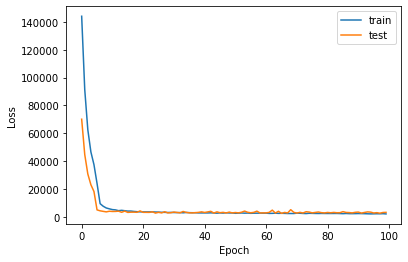

In [10]:
plt.plot(np.arange(0,iter_stop+1,1), cost_arr, label = "train")
plt.plot(np.arange(0,iter_stop+1,1), cost_arr_test, label = "test")

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()